In [100]:
import pandas as pd
import numpy as np
import os
import json
import jsonlines
import plotly.graph_objects as go
import soccerfield
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def load_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [6]:
def load_jsonl_file(file_path):
    with jsonlines.open(file_path, 'r') as file:
        data = [line for line in file if line['timestamp'] is not None]
    return data

In [7]:
match_id = 1133203

In [8]:
file_path = f'data/FA/tracking/{match_id}.jsonl'

In [9]:
data = load_jsonl_file(file_path)

In [10]:
file_path = f'data/FA/match/{match_id}.json'

In [11]:
match_data = load_json_file(file_path)

In [45]:
match_data

{'id': 1133203,
 'home_team_score': 1,
 'away_team_score': 2,
 'date_time': '2023-10-01T11:30:00Z',
 'stadium': {'id': 488,
  'name': 'Villa Park',
  'city': 'Birmingham',
  'capacity': 42682},
 'home_team': {'id': 2029,
  'name': 'Aston Villa, Women',
  'short_name': 'Aston Villa',
  'acronym': 'AVL'},
 'home_team_kit': {'id': 5450,
  'team_id': 2029,
  'season': {'id': 6,
   'start_year': 2019,
   'end_year': 2020,
   'name': '2019/2020'},
  'name': 'Home',
  'jersey_color': '#a50521',
  'number_color': '#ffffff'},
 'away_team': {'id': 2027,
  'name': 'Manchester United, Women',
  'short_name': 'Man Utd, W',
  'acronym': 'MUN'},
 'away_team_kit': {'id': 6537,
  'team_id': 2027,
  'season': {'id': 8,
   'start_year': 2021,
   'end_year': 2022,
   'name': '2021/2022'},
  'name': 'Away',
  'jersey_color': '#ffffff',
  'number_color': '#ff0000'},
 'home_team_coach': None,
 'away_team_coach': None,
 'competition_edition': {'id': 574,
  'competition': {'id': 127,
   'area': 'ENG',
   'name

In [55]:
player_map = {player['id']: f"{player['first_name']} {player['last_name']}-{player['player_role']['position_group']}" for player in match_data['players']}

In [13]:
home_id = match_data['home_team']['id']
away_id = match_data['away_team']['id']

In [14]:
home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]

In [15]:
def map_player_ids(player_list, home_p_ids, away_p_ids):
    return ['H' if player['player_id'] in home_p_ids else 'A' if player['player_id'] in away_p_ids else None for player in player_list]

In [56]:
def map_player(player_list):
    return [player_map[player['player_id']] for player in player_list]

In [75]:
def plot(event_frame):
    frames = [f for f in data if f['frame']>= event_frame-2 and f['frame']<=event_frame+150]
    frames_df = pd.DataFrame(frames)
    frames_df['ball_x'] = frames_df['ball_data'].apply(lambda x: x['x'])
    frames_df['ball_y'] = frames_df['ball_data'].apply(lambda x: x['y'])
    frames_df['p_x'] = frames_df['player_data'].apply(lambda x: [p['x'] for p in x])
    frames_df['p_y'] = frames_df['player_data'].apply(lambda x: [p['y'] for p in x])
    frames_df['team'] = frames_df['player_data'].apply(lambda players: map_player_ids(players, home_p_ids, away_p_ids))
    frames_df['info'] = frames_df['player_data'].apply(lambda players: map_player(players))

    color_map = {'H': 'steelblue', 'A': 'tan'}
    field_layout = soccerfield.get_layout(105, 68)
    
    fig = go.Figure(layout=field_layout)
    fig.update_layout(width=920, height=600, paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor='rgba(0,0,0,0)',
                      margin=dict(l=0, r=100, t=0, b=0),
                      xaxis=dict(showgrid=False, zeroline=False), yaxis=dict(showgrid=False, zeroline=False),
                      legend=dict(xanchor="left", x=1, y=0.85,
                                  font = dict(family = "Roboto, sans-serif", size = 14))
                      )
    
    fig.update_layout(dragmode= False)
    
    for idx, row in frames_df.iterrows():        
        colors = [color_map[value] for value in row['team']]
        fig.add_trace(
            go.Scatter(
                visible=False,
                x=row['p_x'], y=row['p_y'], mode='markers', marker=dict(color=colors), showlegend = False,
                hovertext = row['info'],
                hovertemplate = f'%{{hovertext}}'
            ))
        fig.add_trace(
            go.Scatter(
                visible=False,
                x=[row['ball_x']], y=[row['ball_y']], mode='markers', marker=dict(color='black'), showlegend = False   
            ))
    fig.data[0].visible = True
    fig.data[1].visible = True
    
    visibility = []
    fame_number = frames_df['frame'].to_list()
    for i in range(len(frames)):
        frame_viz = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],
            label = fame_number[i]
        )
        frame_viz["args"][0]["visible"][i*2] = True
        frame_viz["args"][0]["visible"][i*2+1] = True
        visibility.append(frame_viz)
        
    sliders = [dict(
            active=0, steps=visibility, font=dict(size=10)
        )]
    
    fig.update_layout(
            sliders=sliders
        )
    fig.show()

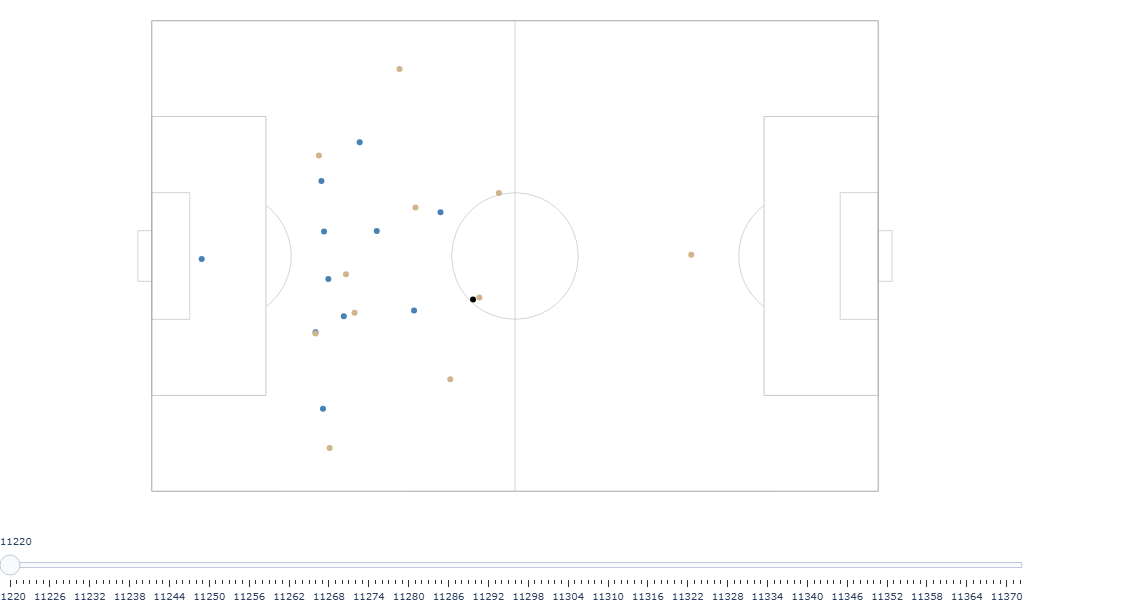

In [86]:
plot(11222)

In [91]:
frames = [f for f in data if f['frame']>= 10369 and f['frame']<=10400]

In [92]:
frames_df = pd.DataFrame(frames)
frames_df['ball_x'] = frames_df['ball_data'].apply(lambda x: x['x'])
frames_df['ball_y'] = frames_df['ball_data'].apply(lambda x: x['y'])
frames_df['p_x'] = frames_df['player_data'].apply(lambda x: [p['x'] for p in x])
frames_df['p_y'] = frames_df['player_data'].apply(lambda x: [p['y'] for p in x])
frames_df['team'] = frames_df['player_data'].apply(lambda players: map_player_ids(players, home_p_ids, away_p_ids))
frames_df['info'] = frames_df['player_data'].apply(lambda players: map_player(players))

In [93]:
frames_df

,frame,timestamp,period,ball_data,possession,image_corners_projection,player_data,ball_x,ball_y,p_x,p_y,team,info
0,10369,00:17:06.90,1,"{'x': 23.48, 'y': 32.38, 'z': 0.2, 'is_detecte...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 12.82, 'y_top_left': 39.0, 'x_b...","[{'x': -29.73, 'y': 3.66, 'player_id': 63552, ...",23.48,32.38,"[-29.73, 0.21, 1.45, 12.27, 10.07, 14.09, 22.4...","[3.66, -1.31, 21.09, -17.46, 29.75, 14.66, -3....","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
1,10370,00:17:07.00,1,"{'x': 24.11, 'y': 32.27, 'z': 0.21, 'is_detect...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 13.18, 'y_top_left': 39.0, 'x_b...","[{'x': -29.72, 'y': 3.7, 'player_id': 63552, '...",24.11,32.27,"[-29.72, 0.23, 1.49, 12.3, 10.06, 14.19, 22.34...","[3.7, -1.18, 21.16, -17.19, 29.8, 15.03, -3.14...","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
2,10371,00:17:07.10,1,"{'x': 24.95, 'y': 32.1, 'z': 0.21, 'is_detecte...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 13.41, 'y_top_left': 39.0, 'x_b...","[{'x': -29.7, 'y': 3.73, 'player_id': 63552, '...",24.95,32.10,"[-29.7, 0.24, 1.54, 12.33, 10.05, 14.29, 22.26...","[3.73, -1.05, 21.23, -16.92, 29.84, 15.38, -3....","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
3,10372,00:17:07.20,1,"{'x': 25.85, 'y': 31.91, 'z': 0.21, 'is_detect...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 13.91, 'y_top_left': 39.0, 'x_b...","[{'x': -29.69, 'y': 3.76, 'player_id': 63552, ...",25.85,31.91,"[-29.69, 0.26, 1.59, 12.37, 10.05, 14.39, 22.1...","[3.76, -0.91, 21.3, -16.65, 29.88, 15.73, -3.1...","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
4,10373,00:17:07.30,1,"{'x': 26.67, 'y': 31.73, 'z': 0.2, 'is_detecte...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 14.24, 'y_top_left': 39.0, 'x_b...","[{'x': -29.67, 'y': 3.78, 'player_id': 63552, ...",26.67,31.73,"[-29.67, 0.28, 1.65, 12.42, 10.06, 14.48, 22.1...","[3.78, -0.77, 21.36, -16.37, 29.91, 16.05, -3....","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
5,10374,00:17:07.40,1,"{'x': 27.38, 'y': 31.55, 'z': 0.2, 'is_detecte...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 14.88, 'y_top_left': 39.0, 'x_b...","[{'x': -29.65, 'y': 3.8, 'player_id': 63552, '...",27.38,31.55,"[-29.65, 0.3, 1.71, 12.47, 10.09, 14.56, 22.09...","[3.8, -0.63, 21.42, -16.08, 29.95, 16.35, -3.0...","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
6,10375,00:17:07.50,1,"{'x': 28.01, 'y': 31.36, 'z': 0.19, 'is_detect...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 14.7, 'y_top_left': 39.0, 'x_bo...","[{'x': -29.64, 'y': 3.81, 'player_id': 63552, ...",28.01,31.36,"[-29.64, 0.32, 1.77, 12.53, 10.12, 14.65, 22.0...","[3.81, -0.48, 21.48, -15.8, 29.99, 16.63, -3.0...","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
7,10376,00:17:07.60,1,"{'x': 28.61, 'y': 31.17, 'z': 0.18, 'is_detect...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 15.24, 'y_top_left': 39.0, 'x_b...","[{'x': -29.62, 'y': 3.82, 'player_id': 63552, ...",28.61,31.17,"[-29.62, 0.35, 1.83, 12.6, 10.16, 14.74, 22.03...","[3.82, -0.34, 21.54, -15.51, 30.04, 16.89, -2....","[H, H, H, H, H, H, H, H, H, H, H, A, A, A, A, ...","[Daphne van Domselaar-Other, Anna Patten-Centr..."
8,10377,00:17:07.70,1,"{'x': 29.18, 'y': 31.02, 'z': 0.18, 'is_detect...","{'player_id': None, 'group': 'home team'}","{'x_top_left': 15.82, 'y_top_left': 39.0, 'x_b...","[{'x': -29.61, 'y': 3.82, 'player_id': 63552, ...",29.18,31.02,"[-29.61, 0.38, 1.9, 12.67, 10.21, 14.83, 22.02...","[3.82, -0.19, 21.6, -15.22, 30.08, 17.13, -2.9...","[H, H, H, H

In [96]:
def explode_data(row):
    # Extract player data into a DataFrame
    players = pd.DataFrame(row['player_data'])
    players['object_type'] = 'player'
    
    # Extract ball data into a DataFrame
    ball = pd.DataFrame([row['ball_data']])
    ball['object_type'] = 'ball'
    ball['player_id'] = None  # Add player_id as NaN for ball
    
    # Combine player and ball data
    combined = pd.concat([players, ball], ignore_index=True)
    
    # Add other columns from the original row
    for col in row.index:
        if col not in ['player_data', 'ball_data']:
            combined[col] = row[col]
    
    return combined

In [102]:
frames_df_2 = frames_df[['frame', 'period', 'ball_data', 'player_data']]

In [103]:
expanded_df = pd.concat(frames_df_2.apply(explode_data, axis=1).to_list(), ignore_index=True)
expanded_df = expanded_df.sort_values(by=['player_id', 'frame']).reset_index(drop=True)

In [107]:
# Calculate differences in x, y, and time for each player
expanded_df['dx'] = expanded_df.groupby('player_id')['x'].diff()
expanded_df['dy'] = expanded_df.groupby('player_id')['y'].diff()

# Calculate speed (Euclidean distance)
expanded_df['speed'] = np.sqrt(expanded_df['dx']**2 + expanded_df['dy']**2)/0.1

# Calculate angle (direction of movement in radians)
expanded_df['angle'] = np.arctan2(expanded_df['dy'], expanded_df['dx'])

In [108]:
expanded_df

,x,y,player_id,is_detected,object_type,z,frame,period,dx,dy,speed,angle
0,16.07,29.59,22457,True,player,NaN,10369,1,NaN,NaN,NaN,NaN
1,16.21,29.62,22457,True,player,NaN,10370,1,0.14,0.03,1.431782,0.211093
2,16.36,29.65,22457,True,player,NaN,10371,1,0.15,0.03,1.529706,0.197396
3,16.50,29.68,22457,True,player,NaN,10372,1,0.14,0.03,1.431782,0.211093
4,16.65,29.70,22457,True,player,NaN,10373,1,0.15,0.02,1.513275,0.132552
5,16.80,29.73,22457,True,player,NaN,10374,1,0.15,0.03,1.529706,0.197396
6,16.95,29.75,22457,True,player,NaN,10375,1,0.15,0.02,1.513275,0.132552
7,17.10,29.78,22457,True,player,NaN,10376,1,0.15,0.03,1.529706,0.197396
8,17.25,29.81,22457,True,player,NaN,10377,1,0.15,0.03,1.529706,0.197396
9,17.40,29.84,22457,True,player,NaN,10378,1,0.15,0.03,1.529706,0.197396
